In [1]:
import os, shutil
import numpy as np
import random
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob
import cv2
import tifffile as tif
import monai
import torch
from skimage import exposure,measure,segmentation,morphology
from monai.inferers import sliding_window_inference

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.set_num_threads(1)

In [4]:
# 返回图片在hsv通道的均值和方差作为特征
def extract_feature(image_path: str):
    feature = []
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    means_hsv, std_hsv = cv2.meanStdDev(img_hsv)

    feature.append(means_hsv)
    feature.append(std_hsv)
    return feature

# 根据已经得到的中心点坐标，返回对应的类别
def cluster(image_path:str):
    centroids =  np.array([[  3.68690462,   0.49137748, 105.81631272,   0.64073039,   0.63384792, 33.09373723],
    [ 88.30804682  ,64.27745113, 188.7468829 ,  52.08498724,  62.11390647, 65.65143542],
    [ 43.63164599 ,111.92362705 , 50.05808066,  37.31790109,  81.6843576, 64.13352828],
    [-9.23705556e-14 ,2.48689958e-14 ,2.80961654e+01, 4.97379915e-14, 2.84217094e-14, 4.35067791e+01]])
    
    feature = extract_feature(image_path=image_path)
    feature = np.array(feature)
    feature = feature[:,:,0]
    feature = feature.reshape(feature.shape[0]*feature.shape[1])

    distance = np.zeros(len(centroids))

    for i in range(len(centroids)):
        distance[i] = np.sqrt(np.sum((feature - centroids[i]) ** 2))
    label = np.argmin(distance)
    return label

def normalize_channel(img, lower=1, upper=99):
    non_zero_vals = img[np.nonzero(img)]
    percentiles = np.percentile(non_zero_vals, [lower, upper])
    if percentiles[1] - percentiles[0] > 0.001:
        img_norm = exposure.rescale_intensity(img, in_range=(percentiles[0], percentiles[1]), out_range='uint8')
    else:
        img_norm = img
    return img_norm.astype(np.uint8)

In [5]:
# 当使用cellpose在大图上进行推理的时候，需要将图片转换为三个类别的mask，处理完再拼回去
def create_interior_map(inst_map):
    """
    Parameters
    ----------
    inst_map : (H,W), np.int16
        DESCRIPTION.

    Returns
    -------
    interior : (H,W), np.uint8 
        three-class map, values: 0,1,2
        0: background
        1: interior
        2: boundary
    """
    # create interior-edge map
    boundary = segmentation.find_boundaries(inst_map, mode='inner')
    boundary = morphology.binary_dilation(boundary, morphology.disk(1))

    interior_temp = np.logical_and(~boundary, inst_map > 0)
    # interior_temp[boundary] = 0
    interior_temp = morphology.remove_small_objects(interior_temp, min_size=16)
    interior = np.zeros_like(inst_map, dtype=np.uint8)
    interior[interior_temp] = 1
    interior[boundary] = 2
    return interior
    

In [6]:
def baseline_inference(img_data,model):
    # 定义baseline的模型，用于推理荧光图像
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        roi_size = (512,512)
        sw_batch_size = 1
        model.eval()

        # noramalize the data
        if len(img_data.shape) == 2:
                        img_data = np.repeat(np.expand_dims(img_data, axis=-1), 3, axis=-1)
        elif len(img_data.shape) == 3 and img_data.shape[-1] > 3:
                img_data = img_data[:,:, :3]
        else:
                pass
        pre_img_data = np.zeros(img_data.shape, dtype=np.uint8)
        for i in range(3):
                img_channel_i = img_data[:,:,i]
                if len(img_channel_i[np.nonzero(img_channel_i)])>0:
                        pre_img_data[:,:,i] = normalize_channel(img_channel_i, lower=1, upper=99)
        with torch.no_grad():
                test_npy01 = pre_img_data/np.max(pre_img_data)
                test_tensor = torch.from_numpy(np.expand_dims(test_npy01, 0)).permute(0,3,1,2).type(torch.FloatTensor).to(device)
                test_pred_out = sliding_window_inference(test_tensor, roi_size, sw_batch_size, model)
                test_pred_out = torch.nn.functional.softmax(test_pred_out, dim=1) # (B, C, H, W)
                test_pred_npy = test_pred_out[0,1].cpu().numpy()
                # convert probability map to binary mask and apply morphological postprocessing
                test_pred_mask = measure.label(morphology.remove_small_objects(morphology.remove_small_holes(test_pred_npy>0.5),16))
                # test_pred_mask = measure.label(test_pred_npy>0.5)
        return test_pred_mask

In [7]:
def cellpose_inference(img,model,chan,diam):
    masks, flows, styles = model.eval(img, 
                                    channels=chan,
                                    diameter=diam,
                                    flow_threshold=0.4,
                                    cellprob_threshold=0
                                    )
    return masks

In [8]:
def wsi_inference(img,model,chan,diam):
    patch_size = 512
    height = img.shape[0]
    width = img.shape[1]
    masks = np.zeros((img.shape[0],img.shape[1]))
    for h in range(0,height,patch_size):
        for w  in range(0,width,patch_size):
            patch = img[h:h+patch_size,w:w+patch_size]
            patch_mask, flows, styles = model.eval(patch, 
                                    channels=chan,
                                    diameter=diam,
                                    flow_threshold=0.4,
                                    cellprob_threshold=0
                                    ) 
            masks[h:h+patch_size,w:w+patch_size] = patch_mask
    return masks


In [9]:
tuning_dir = '/data112/NeurISP2022-CellSeg/TuningSet/'
logger = io.logger_setup()
cluster_model = []
for i in range(5):
    model_path = '/data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_{}/models/cellpose_cluster_v{}'.format(i,i)
    model = models.CellposeModel(gpu=True, 
                                pretrained_model=model_path)
    cluster_model.append(model)

# 替换掉荧光图像的推理模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model = monai.networks.nets.SwinUNETR(
                img_size=(256, 256), 
                in_channels=3, 
                out_channels=3,
                feature_size=24, # should be divisible by 12
                spatial_dims=2
                ).to(device)
checkpoint = torch.load(os.path.join('/data112/wzy/NIPS/baseline/work_dir/deeplab_transformer_3class', 'best_Dice_model2_0.7406.pth'), map_location=torch.device(device))
baseline_model.load_state_dict(checkpoint['model_state_dict'])
cluster_model[2] = baseline_model


imgs_path = os.listdir(tuning_dir)
imgs_path.sort()
# imgs_path = imgs_path[0:-1]         # 那张wsi不能这么处理
chan = [[2,0],[2,0],[3,0],[0,0],[0,0]]
diam = [45,45,15,45,45]
for i,img_path in enumerate(imgs_path):
    img = io.imread(tuning_dir+img_path)
    img_name = img_path.split('.')[0]
    print(img_name)
    label = cluster(os.path.join(tuning_dir,img_path))
    print(label)
    if(label == 2):
        masks = baseline_inference(img,cluster_model[label])

    elif(label == 0 or label == 3):
        label = 4
        masks = cellpose_inference(img,cluster_model[label],chan[label],diam[label])
        masks_reverse = cellpose_inference(255-img,cluster_model[label],chan[label],diam[label])
        a = len(np.unique(masks,return_index=False,return_counts=True,return_inverse=False)[0])
        b = len(np.unique(masks_reverse,return_index=False,return_counts=True,return_inverse=False)[0])
        if(a < b):masks = masks_reverse

        if(len(np.unique(masks,return_index=False,return_counts=True,return_inverse=False)[0])<= 5):
            masks = baseline_inference(img,cluster_model[2])
    else:
        masks = cellpose_inference(img,cluster_model[label],chan[label],diam[label])
        # masks_reverse = cellpose_inference(255-img,cluster_model[label],chan[label],diam[label])
        # a = len(np.unique(masks,return_index=False,return_counts=True,return_inverse=False)[0])
        # b = len(np.unique(masks_reverse,return_index=False,return_counts=True,return_inverse=False)[0])
        # if(a < b):masks = masks_reverse

        # if(len(np.unique(masks,return_index=False,return_counts=True,return_inverse=False)[0])<= 5):
        #     masks = baseline_inference(img,cluster_model[2])
    print('/data112/wzy/NIPS/baseline/work_dir/output1/'+img_name+'_label.tiff')
    tif.imwrite('/data112/wzy/NIPS/baseline/work_dir/output1/'+img_name+'_label.tiff',masks,compression='zlib')

2022-09-22 19:52:37,422 [INFO] WRITING LOG OUTPUT TO /home/wzy/.cellpose/run.log
2022-09-22 19:52:37,429 [INFO] >>>> loading model /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_0/models/cellpose_cluster_v0
2022-09-22 19:52:48,053 [INFO] ** TORCH CUDA version installed and working. **
2022-09-22 19:52:48,056 [INFO] >>>> using GPU
2022-09-22 19:52:49,056 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2022-09-22 19:52:49,057 [INFO] >>>> model diam_labels =  45.290 (mean diameter of training ROIs)
2022-09-22 19:52:49,063 [INFO] >>>> loading model /data112/wzy/NIPS/data/Train_Pre_3class/cluster/class_1/models/cellpose_cluster_v1
2022-09-22 19:52:49,082 [INFO] ** TORCH CUDA version installed and working. **
2022-09-22 19:52:49,083 [INFO] >>>> using GPU
2022-09-22 19:52:51,230 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2022-09-22 19:52:51,232 [INFO] >>>> model diam_labels =  147.525 (mean diameter of training 

KeyboardInterrupt: 

In [16]:
masks_dir = '/data112/wzy/NIPS/baseline/work_dir/output1'
masks_path = os.listdir(masks_dir)
masks_path.sort()
for i,mask_path in enumerate(masks_path):
    print(mask_path)
    test_mask = io.imread(os.path.join(masks_dir,mask_path))
    print('pic_{}'.format(i+1))
    print(len(np.unique(test_mask,return_index=False,return_counts=True,return_inverse=False)[0]))         #检查一下得到的mask图像中实例的数量，如果小于5会导致提交失败


cell_00001_label.tiff
pic_1
15
cell_00002_label.tiff
pic_2
56
cell_00003_label.tiff
pic_3
24
cell_00004_label.tiff
pic_4
17
cell_00005_label.tiff
pic_5
29
cell_00006_label.tiff
pic_6
39
cell_00007_label.tiff
pic_7
23
cell_00008_label.tiff
pic_8
14
cell_00009_label.tiff
pic_9
289
cell_00010_label.tiff
pic_10
123
cell_00011_label.tiff
pic_11
14
cell_00012_label.tiff
pic_12
210
cell_00013_label.tiff
pic_13
29
cell_00014_label.tiff
pic_14
25
cell_00015_label.tiff
pic_15
18
cell_00016_label.tiff
pic_16
27
cell_00017_label.tiff
pic_17
24
cell_00018_label.tiff
pic_18
35
cell_00019_label.tiff
pic_19
12
cell_00020_label.tiff
pic_20
32
cell_00021_label.tiff
pic_21
32
cell_00022_label.tiff
pic_22
28
cell_00023_label.tiff
pic_23
39
cell_00024_label.tiff
pic_24
24
cell_00025_label.tiff
pic_25
59
cell_00026_label.tiff
pic_26
162
cell_00027_label.tiff
pic_27
13
cell_00028_label.tiff
pic_28
76
cell_00029_label.tiff
pic_29
62
cell_00030_label.tiff
pic_30
44
cell_00031_label.tiff
pic_31
116
cell_00032_l

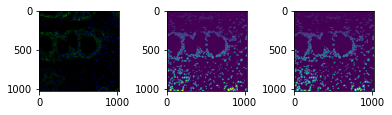

In [8]:
test_img = io.imread('/data112/NeurISP2022-CellSeg/TuningSet/cell_00043.png')
test_mask = io.imread('/data112/wzy/NIPS/baseline/work_dir/output2/cell_00043_label.tiff')      
test_mask1 = io.imread('/data112/wzy/NIPS/baseline/work_dir/output1/cell_00043_label.tiff')      #baseline训练出的模型得到的结果

f = plt.figure()
f.subplots_adjust(hspace=0.6, wspace=0.6)
f.add_subplot(1, 3, 1)
plt.imshow(test_img)
f.add_subplot(1, 3, 2)
plt.imshow(test_mask )
f.add_subplot(1, 3, 3)
plt.imshow(test_mask1)

In [11]:
test_mask2 = np.uint8(test_mask1)
markers3 = cv2.watershed(test_img, test_mask1)
plt.imshow(markers3)
# plt.imshow(test_mask2)

error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'watershed'


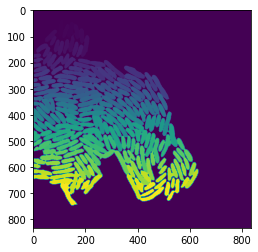

In [7]:
test_mask1 = io.imread('/data112/wzy/NIPS/baseline/work_dir/output1/cell_00078_label.tiff')      #baseline训练出的模型得到的结果
plt.imshow(test_mask1)

In [2]:
try_img = io.imread('/data112/NeurISP2022-CellSeg/TuningSet/cell_00043.png')
# try_img = 255 - try_img
masks = baseline_inference(try_img,cluster_model[2])
# masks = cellpose_inference(try_img,cluster_model[4],[0,0],45)
plt.imshow(masks)

NameError: name 'baseline_inference' is not defined

In [19]:
tif.imwrite('/data112/wzy/NIPS/baseline/work_dir/output1/'+'cell_00078'+'_label.tiff',masks,compression='zlib')